In [1]:
import os
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


**CONEXIÓN A BASE DE DATOS**                          

In [2]:
conect = psycopg2.connect(
    host="localhost",
    port="5432",
    database="postgres",
    user="postgres",
    password="JONPER"
)

query = """
SELECT fecha_hora, nombre_gnss,
       desp_2d_mm,
       tasa_3d_mm_d,
       azimut
FROM "MV_GNSS"."03_gnss_data_procesada"
ORDER BY fecha_hora DESC;
"""

df = pd.read_sql(query, conect)
df.head()

C:\Users\jonat\AppData\Local\Temp\ipykernel_29692\531201984.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conect)


,fecha_hora,nombre_gnss,desp_2d_mm,tasa_3d_mm_d,azimut
0,2025-12-11 16:00:00,GNSSJZ,0.0000,0.0000,0.0000
1,2025-12-11 16:00:00,GNSS04,4.3267,0.3383,269.3334
2,2025-12-11 16:00:00,GNSS01,4.9980,-1.3118,269.6383
3,2025-12-11 16:00:00,GNSS03,4.2720,-1.0266,269.3611
4,2025-12-11 16:00:00,GNSS02,1.5811,1.0797,270.3333


***RANGO DE FECHAS A GRAFICAR***

In [3]:
df['fecha'] = pd.to_datetime(df['fecha_hora'])
df = df[df['fecha'].between('2025-11-27 00:00:00',  #PUNTO INICIAL
                            '2025-12-04 23:59:59'   #PUNTO FINAL
                            )]
df = df.dropna(subset=["azimut", "desp_2d_mm"])
df = df[df["desp_2d_mm"] > 0]

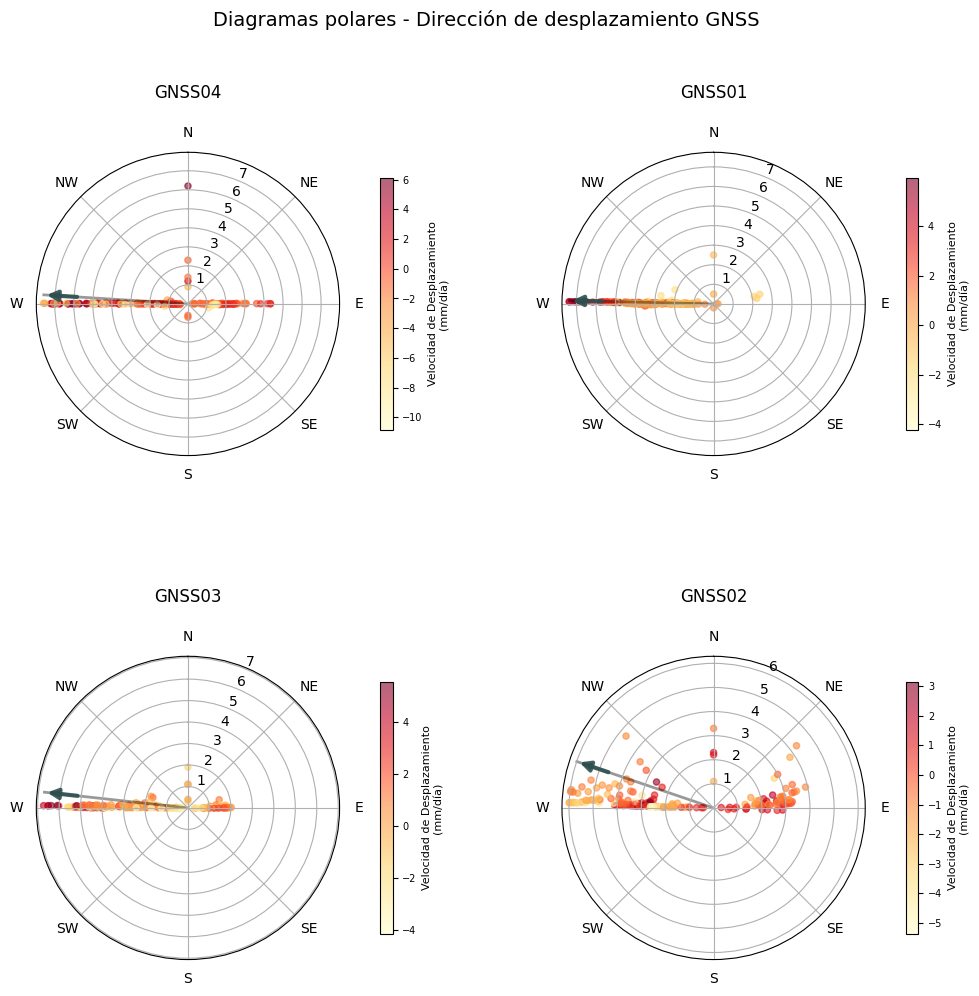

In [4]:
# Obtiene una lista con todos los nombres únicos de estaciones GNSS del DataFrame
gnss_list = df["nombre_gnss"].unique()

# Crea una figura con 4 subgráficos (2x2) en coordenadas polares
# - 2, 2: crea una cuadrícula de 2 filas x 2 columnas
# - figsize: tamaño de la figura completa en pulgadas (ancho, alto)
# - projection="polar": hace que cada subgráfico use coordenadas polares (círculo/brújula)
fig, axes = plt.subplots(
    2, 2,
    figsize=(12, 12),
    subplot_kw={"projection": "polar"}
)

# Convierte la matriz 2D de ejes en un array 1D para iterar más fácilmente
# De [[ax1, ax2], [ax3, ax4]] → [ax1, ax2, ax3, ax4]
axes = axes.flatten()

# Itera sobre cada subgráfico (ax) y su estación GNSS correspondiente
for ax, gnss in zip(axes, gnss_list):
    
    # Filtra el DataFrame para obtener solo los datos de la estación GNSS actual
    dfg = df[df["nombre_gnss"] == gnss]
    
    # Prepara los datos para el gráfico polar:
    # theta = ángulo/dirección (azimut convertido de grados a radianes)
    theta = np.deg2rad(dfg["azimut"].values)
    # r = radio/magnitud (distancia desde el centro = desplazamiento en mm)
    r = dfg["desp_2d_mm"].values
    # c = color (basado en la velocidad/tasa de desplazamiento en mm/día)
    c = dfg["tasa_3d_mm_d"].values
    
    # Crea el gráfico de dispersión (scatter) en coordenadas polares
    # - theta: dirección de cada punto (ángulo)
    # - r: distancia desde el centro (magnitud)
    # - c: valor que determina el color según el mapa de colores
    # - cmap: mapa de colores (Amarillo-Naranja-Rojo)
    # - s: tamaño de los puntos en pixels²
    # - alpha: transparencia (0=invisible, 1=opaco)
    sc = ax.scatter(theta, r, c=c, cmap="YlOrRd", s=20, alpha=0.6)
    
    # === Configuración del sistema de coordenadas polares ===
    
    # Coloca el 0° en la parte superior (Norte), como una brújula
    ax.set_theta_zero_location("N")
    
    # Hace que los ángulos aumenten en sentido horario (como brújula real)
    # -1 = horario, 1 = antihorario
    ax.set_theta_direction(-1)
    
    # Configura las etiquetas de los ángulos cada 45 grados
    # range(0, 360, 45): posiciones en 0°, 45°, 90°, 135°, 180°, 225°, 270°, 315°
    # labels: etiquetas de los 8 puntos cardinales principales
    ax.set_thetagrids(
        range(0, 360, 45),
        labels=["N","NE","E","SE","S","SW","W","NW"]
    )
    
    # === Cálculo de la dirección dominante (promedio vectorial) ===
    
    # Calcula el promedio de las componentes X (Este-Oeste) de todos los vectores
    # sin(theta) da la componente horizontal de cada vector
    x_mean = np.mean(np.sin(theta))
    
    # Calcula el promedio de las componentes Y (Norte-Sur) de todos los vectores
    # cos(theta) da la componente vertical de cada vector
    y_mean = np.mean(np.cos(theta))
    
    # Calcula el ángulo resultante usando arcotangente de 2 argumentos
    # arctan2(x, y) maneja correctamente todos los cuadrantes y evita división por cero
    # Esto da la dirección promedio/dominante del movimiento
    theta_mean = np.arctan2(x_mean, y_mean)
    
    # === Dibuja la línea de dirección dominante ===
    
    # Traza una línea recta desde el centro hasta el borde del gráfico
    # que indica la dirección promedio del desplazamiento
    ax.plot(
        [theta_mean, theta_mean],  # Mismo ángulo en inicio y fin (línea radial)
        [0, r.max()],               # Desde el centro (0) hasta el desplazamiento máximo
        color="black",              # Color de la línea
        linewidth=2,                # Grosor de la línea
        alpha=0.4,                  # Semi-transparente (40% opaco) para no tapar puntos
        zorder=1                    # Profundidad: 1 = atrás (los puntos tienen zorder=2)
    )
    
    # === Agrega una flecha al final de la línea de dirección ===
    
    # annotate() dibuja una anotación (en este caso, solo una flecha sin texto)
    ax.annotate(
        '',  # Texto vacío, solo queremos la flecha visual
        xy=(theta_mean, r.max()),        # Posición de la punta de la flecha (destino)
        xytext=(theta_mean, r.max()*0.75),  # Posición de la cola (origen, al 75% del radio)
        arrowprops=dict(                 # Diccionario con propiedades de la flecha
            arrowstyle='-|>',            # Estilo: flecha con base perpendicular →|
            color='#2F4F4F',             # Color verde oscuro/gris oscuro (DarkSlateGray)
            lw=3,                        # Grosor de la línea de la flecha (linewidth)
            alpha=0.9,                   # Casi opaca (90% visible)
            mutation_scale=15            # Tamaño de la cabeza de la flecha
        ),
        zorder=3  # Profundidad: 3 = al frente (sobre los puntos y la línea)
    )
    
    # Establece el título del subgráfico con el nombre de la estación GNSS
    ax.set_title(gnss, pad=20)
    
    # === Crea una barra de color INDIVIDUAL para este subgráfico ===
    
    cbar = fig.colorbar(
        sc,                      # Objeto scatter del cual tomar la escala de colores
        ax=ax,                   # Asocia la barra SOLO a este subgráfico (no a todos)
        orientation="vertical",  # Orientación vertical (también puede ser "horizontal")
        shrink=0.6,              # Reduce el tamaño al 60% de la altura del gráfico
        pad=0.1                  # Separación entre el gráfico y la barra de color
    )
    
    # Etiqueta de la barra de color
    cbar.set_label("Velocidad de Desplazamiento\n(mm/día)", fontsize=8)
    
    # Ajusta el tamaño de los números (ticks) en la barra de color
    cbar.ax.tick_params(labelsize=7)

# === Oculta los subgráficos que no se usan ===

# Si hay menos de 4 estaciones GNSS, oculta los gráficos vacíos sobrantes
# range(len(gnss_list), len(axes)): desde el número de estaciones hasta 4
for i in range(len(gnss_list), len(axes)):
    axes[i].set_visible(False)  # Hace invisible el subgráfico vacío

# === Título general de toda la figura ===

fig.suptitle(
    "Diagramas polares - Dirección de desplazamiento GNSS",
    fontsize=14,  # Tamaño de fuente del título
    y=0.95        # Posición vertical (0.98 = 98% desde abajo, cerca del borde superior)
)

# === Ajusta el espaciado entre subgráficos ===

plt.subplots_adjust(
    wspace=0.30,  # Espacio horizontal entre columnas (0-1, donde 0.4 = 40% del ancho)
    hspace=0.20  # Espacio vertical entre filas (0-1, donde 0.35 = 35% de la altura)
)

# Muestra la figura completa en pantalla
plt.show()

In [7]:
gnss_list = df["nombre_gnss"].unique()

for gnss in gnss_list:
    
    dfg = df[df["nombre_gnss"] == gnss]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "polar"})
    
    theta = np.deg2rad(dfg["azimut"].values)
    r = dfg["desp_2d_mm"].values
    c = dfg["tasa_3d_mm_d"].values
    
    sc = ax.scatter(theta, r, c=c, cmap="YlOrRd", s=35, alpha=0.7)
    
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_thetagrids(
        range(0, 360, 45),
        labels=["N","NE","E","SE","S","SW","W","NW"]
    )
    ax.set_rgrids(
    range(0, int(r.max())+1, int(r.max()/4)),
    labels=[f"{int(val)} mm" for val in range(0, int(r.max())+1, int(r.max()/4))],
    angle=45, fontsize=8
)
    
    # Dirección dominante
    x_mean = np.mean(np.sin(theta))
    y_mean = np.mean(np.cos(theta))
    theta_mean = np.arctan2(x_mean, y_mean)
    
    ax.plot([theta_mean, theta_mean], [0, r.max()], 
            color="black", 
            linewidth=2, 
            alpha=0.4,
            zorder=1)
    
    ax.annotate('', xy=(theta_mean, r.max()), 
                xytext=(theta_mean, r.max()*0.80),
                arrowprops=dict(arrowstyle='-|>', 
                                color='#2F4F4F', 
                                lw=3, # Grosor de la flecha
                                alpha=0.9,
                                mutation_scale=20          # Tamaño de la cabeza de la flecha
                                ),
                zorder=3)
    
    # Barra de color
    cbar = fig.colorbar(sc, ax=ax, shrink=0.5, pad=0.1)
    cbar.set_label("Velocidad Desplazamiento (mm/día)", fontsize=12)
    
    ax.set_title(f"Dirección de Desplazamiento - {gnss}", fontsize=14, pad=20)
    
    plt.tight_layout()
    
    # Guarda cada gráfico con el nombre de la estación
    plt.savefig(f"polar_{gnss}.png", dpi=300, bbox_inches='tight')
    print(f"✓ Guardado: polar_{gnss}.png")
    
    plt.close()  # Cierra la figura para liberar memoria

print("¡Todos los gráficos guardados!")

✓ Guardado: polar_GNSS04.png
✓ Guardado: polar_GNSS01.png
✓ Guardado: polar_GNSS03.png
✓ Guardado: polar_GNSS02.png
¡Todos los gráficos guardados!
